# Schechter redshift-dependent & GMM comparison

In [1]:
import copy
import os
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

### Methods

#### Mass completeness limit $M(z)$

In [3]:
def mass_completeness_limit(z):
    f, b, c = [-1.34199453, 13.90578909,  8.53522654]
    return 4*np.pi*f*z**2 + b*z + c

#### Mass completeness limit inverse $z(M_{*})$

In [4]:
def zmax_mass_completeness_limit(m):
    f, b, c = [-1.34199453, 13.90578909, 8.53522654]

    discriminant = -16*np.pi*f*c + 16*np.pi*f*m + b**2
    sqrt_discriminant = np.sqrt(discriminant)

    z1 = (-b + sqrt_discriminant) / (8 * np.pi * f)
    
    return z1

#### Selecting data

In [5]:
def gathering_data(bgs, zmin, zmax):
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & \
                (np.median(bgs['provabgs_logMstar'].data, axis=1) > mass_completeness_limit(bgs['Z_HP'].data))

    z = bgs['Z_HP'].data[mask_zlim]
    x = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median = np.median(x, axis=1)
    w_zfail = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax = bgs['Vmax'].data[mask_zlim]
    w_spec = bgs['provabgs_w_zfail'].data[mask_zlim] * bgs['provabgs_w_fibassign'].data[mask_zlim]
    
    return z, x, x_median, w_spec, vmax
    
    
# def gathering_data(data, zmin, zmax):

#     bgs = data
#     mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
#     z_tot = bgs['Z_HP'].data[mask_zlim]
#     x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
#     x_median_tot = np.median(x_tot, axis=1)
#     w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
#     w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
#     vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
#     mass_comp_lim = mass_completeness_limit(z_tot)
#     # mask_mlim = []
#     # for i in range(len(x_median_tot)):
#     #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
#     mask_mlim = x_median_tot > mass_completeness_limit(z_tot)
        
    
#     mask = (w_zfail_tot > 0) & (mask_mlim)
    
#     z = z_tot[mask].astype(np.float32)
#     x = x_tot[mask].astype(np.float32)
#     x_median = x_median_tot[mask].astype(np.float32)
#     w_zfail = w_zfail_tot[mask].astype(np.float32)
#     w_fib = w_fib_tot[mask].astype(np.float32)
#     vmax = vmax_tot[mask].astype(np.float32)
    
    
#     f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
#     v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
#     v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
#     v_sub = v_zmax - v_zmin
    
    
#     # w_spec * 1/Vmax
#     w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
#     n = np.sum(w)/v_sub
    
#     # Spectroscopic weights
#     w_spec = (w_zfail*w_fib)

#     return z, x, x_median, w_spec, vmax


def noz_gathering_data(data, zmin, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec, vmax, v_zmax, v_zmin

#### Schechter function $\phi(M_{*}, z)$

In [6]:
def smf_single_schechter_sty_z0(x, z0, a0, a1, a2, a3):
    logM = a0 + a1 * z0
    alpha1 = a2 + a3 * z0
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
    logM = a0 + a1 * z
    alpha1 = a2 + a3 * z
    
    term0 = np.exp(-10 ** (x-logM[:,None]))
    term1 = 10 ** ((alpha1+1)[:,None]*(x - logM[:,None]))
    return term0 * term1



def smf_single_schechter_integral(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def noz_smf_single_schechter_sty(x, logM, alpha1):
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1

#### Log Likelihood - prior - posterior

In [7]:
def log_likelihood(a0, a1, a2, a3, w, z, x):
    q = smf_single_schechter_sty(x, z, a0, a1, a2, a3)

    mlim = mass_completeness_limit(z)
    I = [integrate.quad(smf_single_schechter_integral, mlim[i], 13., args=(z[i], a0, a1, a2, a3))[0] for i in range(z.shape[0])]

    a = np.log10(np.sum(q, axis=1)) - np.log10(I)
    
    return a * w


# def log_likelihood(logM, alpha1, w, x, z):
#     I = []
#     mlim = mass_completeness_limit(z)
#     for i in range(z.shape[0]):
#         I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
#     q = smf_single_schechter_sty(x, logM, alpha1)
#     a = np.log10(np.sum(q, axis=1)) - np.log10(I)
#     return a * w


def log_prior(theta):
    a0, a1, a2, a3 = theta
    if 9.5 < a0 < 13.5 and \
        0. < a1 < 4. and \
       -2.5 < a2 < -0.5  and \
       0. < a3 < 3.:
        return 0
    return -np.inf



def posterior(theta, w, x, z):
    a0, a1, a2, a3 = theta
    l = log_likelihood(a0, a1, a2, a3, w, z, x)
    return log_prior(theta) + np.sum(l)

#### Normalisation

In [8]:
def v_tot(f_area, z):
    v_min = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area
    v_max = Planck13.comoving_volume(z).value * Planck13.h**3 * f_area
    return v_max  - v_min



def normalisation(bgs, f_area, z0, best_params):
    a0, a1, a2, a3 = best_params
    zmin = 0.01

    # z, x, x_median, w_spec, vmax = gathering_data(data, zmin, z0)
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(z0).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / bgs['Vmax'].data
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < z0)& \
                (np.median(bgs['provabgs_logMstar'].data, axis=1) > mass_completeness_limit(bgs['Z_HP'].data))
    
    
    I = []
    mlim = mass_completeness_limit(bgs['Z_HP'].data[zlim])
    for i in range(mlim.shape[0]):
        I.append(integrate.quad(smf_single_schechter_integral, mlim[i], 13., args=(z0, a0, a1, a2, a3))[0])

    
    # return (1/v_tot(f_area,z0))* np.sum(w_spec/np.array(I)) THIS IS THE ONE FROM THE PAPER
    return np.sum(w_import[zlim]/np.array(I))/(v_zmax - v_zmin), I


def noz_normalisation(f_area, w_spec, vmax, v_zmin, z, best_params):
    logM, alpha1 = best_params
    
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(noz_smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    
    # return (1/v_tot(f_area,z0))* np.sum(w_spec/np.array(I)) THIS IS THE ONE FROM THE PAPER
    return np.sum(w_spec/np.array(I)/(vmax-v_zmin)), I

#### Gaussian Mixture Model

In [9]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

#### $1/V_{max}$ histogram

In [10]:
def norm_hist_mine(bgs, zmin, zmax):
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & \
                (np.median(bgs['provabgs_logMstar'].data, axis=1) > mass_completeness_limit(bgs['Z_HP'].data))

    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    # v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    # v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = 1. / bgs['Vmax'].data[zlim]
    w_import *= bgs['provabgs_w_zfail'].data[zlim] * bgs['provabgs_w_fibassign'].data[zlim]

    # calculate normalization
    # norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)

    _h, _be, _ = plt.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import/np.sum(w_import),
             range=(6., 13.), bins=40, histtype='step', 
             color='b', linestyle='--', linewidth=1)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.xlim(7., 13.)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
    plt.yscale('log')
    plt.ylim(5e-7, 1e2)

    return _h, _be, _

    
def norm_hist(bgs, zmin, zmax):
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & \
                (np.median(bgs['provabgs_logMstar'].data, axis=1) > mass_completeness_limit(bgs['Z_HP'].data))

    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)

    _h, _be, _ = plt.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]/np.sum(w_import[zlim]) * norm, 
             range=(6., 13.), bins=40, histtype='step', 
             color='k', linewidth=0.5)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.xlim(7., 13.)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
    plt.yscale('log')
    plt.ylim(5e-7, 1e-1)

    return _h, _be, _



def norm_hist_all(bgs, zmin, zmax):
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)

    _h, _be, _ = plt.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]/np.sum(w_import[zlim]) * norm, 
             range=(6., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=0.3)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.xlim(7., 13.)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
    plt.yscale('log')
    plt.ylim(5e-7, 1e-1)

    return _h, _be, _

## Directories and File to load

In [11]:
data_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/data'
emcee_runs_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/bin_tests_runs'
gmm_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/gmm'

data_file = 'BGS_ANY_full.provabgs.lite.hdf5'
# filename = "ZSchechter_50w_600step_0.01_0.4.h5"
filename = "ZSchechter_50w_600step_0.01_0.3.h5"

## Selecting Data

In [12]:
path_to_data = os.path.join(data_dir,data_file)

bgs = aTable.Table.read(path_to_data)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))

zmax = 0.1 
zmin = 0.01
z0 = 0.045

z_tot, x_tot, x_median_tot, w_spec_tot, v_max_tot = gathering_data(bgs, zmin, 0.4)
z, x, x_median, w_spec, v_max = gathering_data(bgs, zmin, zmax)

In [13]:
z.shape, x_median.shape, w_spec.shape, x.shape, v_max.shape, bgs['Z_HP'].max()

((14824,), (14824,), (14824,), (14824, 100), (14824,), 0.59899602949955)

### Data plot

(6.0, 13.2)

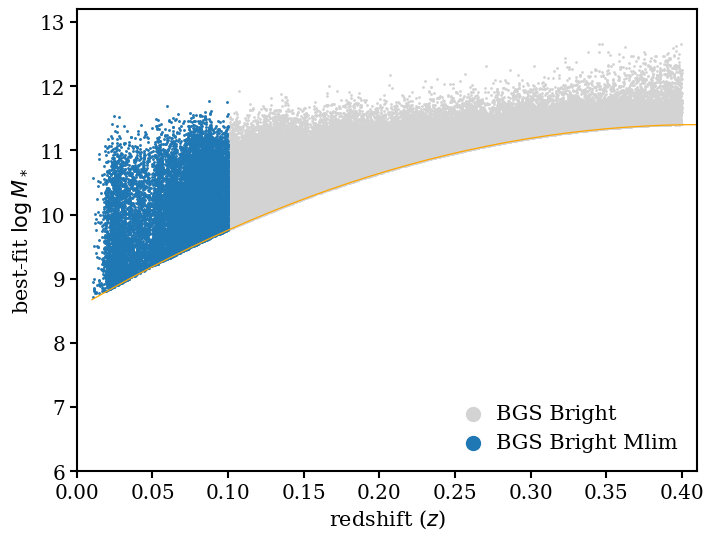

In [14]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(z_tot, x_median_tot, 
            s=1, c='lightgrey', label='BGS Bright')

sub.scatter(z, x_median, 
            s=1, c='C0', label='BGS Bright Mlim')


sub.plot(np.linspace(0.01, 0.65), mass_completeness_limit(np.linspace(0.01, 0.65)),
         color = 'orange', linewidth=0.9)


# sub.scatter(pt[problems[0]][:,5], pt[problems[0]][:,4], c='red', s=1)


sub.legend(loc='lower right', fontsize=15, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=15)
sub.set_xlim(0., 0.41)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
sub.set_ylim(6., 13.2)

## Emcee plots

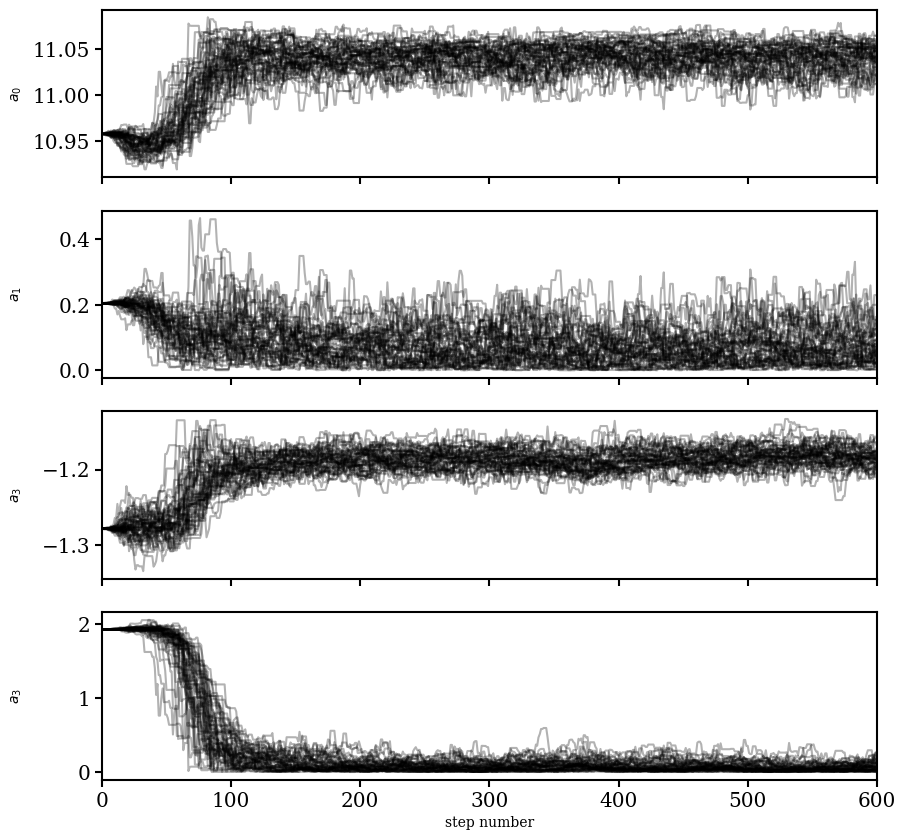

In [15]:
emcee_run = os.path.join(emcee_runs_dir,filename)
reader = emcee.backends.HDFBackend(emcee_run)
samples = reader.get_chain()

ndim = 4
labels = [r'$a_{0}$', r'$a_{1}$', r'$a_{3}$', r'$a_{3}$']


fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

# plt.show()
# plt.subplots_adjust(bottom=0.2)

In [16]:
# emcee_run = os.path.join(emcee_runs_dir,'/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/redshift_fit_1Schechter_2_50w_600s_v4_newgrid.h5')
# reader = emcee.backends.HDFBackend(emcee_run)
# samples = reader.get_chain()

# ndim = 4
# labels = [r'$a_{0}$', r'$a_{1}$', r'$a_{3}$', r'$a_{3}$']


# fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)

# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)
#     axes[-1].set_xlabel("step number")


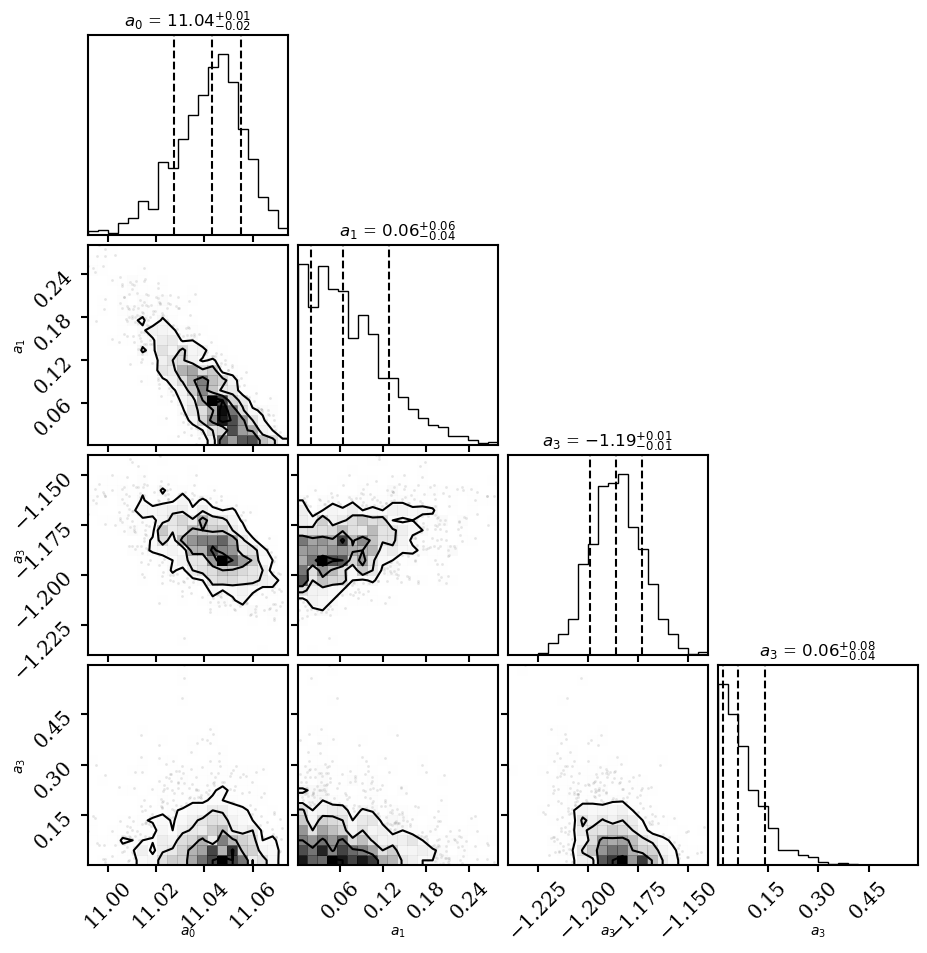

In [17]:
flat_samples = reader.get_chain(discard=150, thin=15, flat=True) 
fig = corner.corner(flat_samples, labels=labels, quantiles=(0.16, 0.50, 0.84), show_titles=True);
plt.show()

In [18]:
mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(flat_samples.shape[1])])
a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc = mcmc[:,1]

## Plot $1/V_{max}$ - $\Phi(M_{*}, z_0)$

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/3756427143.py:37: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)
/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/3756427143.py:65: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


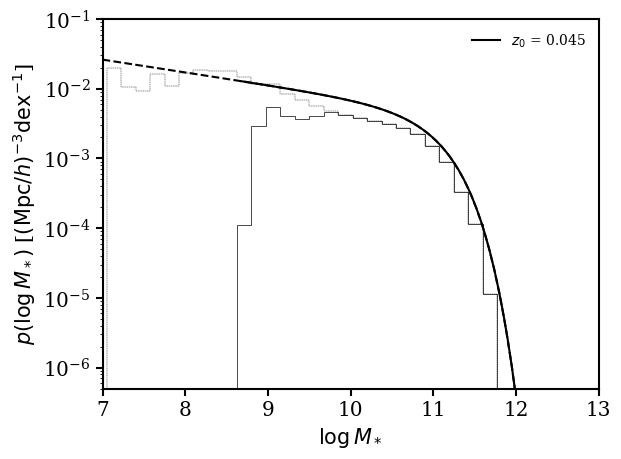

In [19]:
_h, _be, _ = norm_hist(bgs, zmin, zmax)
norm_hist_all(bgs, zmin, zmax)
# norm_hist_mine(bgs, zmin, zmax)
n, I = normalisation(bgs, f_area, z0, mcmc[:,1])

x_lin = np.linspace(mass_completeness_limit(0.01), 14, 100)
x_lin_ext = np.linspace(7,14,100)

plt.plot(x_lin, n * smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), c='k', label = f'$z_0$ = {z0}')
plt.plot(x_lin_ext, n * smf_single_schechter_sty_z0(x_lin_ext, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), c='k', linestyle = '--')

plt.legend(loc='best')

In [20]:
n

0.004747563937299086

In [21]:
zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3

w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

# calculate normalization
norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
weight = w_import[zlim]/np.sum(w_import[zlim]) * norm
print(norm, np.sum(weight), np.sum(w_import[zlim]/(v_zmax - v_zmin)))

0.22443208390994773 0.22443208390994773 0.22443208390994773


/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/2015917397.py:6: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


In [22]:
w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data[zlim] - v_zmin)
w_import *= bgs['provabgs_w_zfail'].data[zlim] * bgs['provabgs_w_fibassign'][zlim]

# calculate normalization
norm = np.sum(w_import) / (v_zmax - v_zmin)
print(norm)

0.20344123855449833


In [23]:
np.sum(bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin), np.sum(bgs['Vmax'].data[zlim]), \
np.sum(bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) - np.sum(bgs['Vmax'].data[zlim])

(61121180181.43839, 48444158260.57196, 12677021920.866432)

In [24]:
# w_import.shape, w_import[zlim].shape, np.sum(w_import[zlim]) / (v_zmax - v_zmin), b

In [25]:
w_import = 1. / bgs['Vmax'].data[zlim]
w_import *= bgs['provabgs_w_zfail'].data[zlim] * bgs['provabgs_w_fibassign'].data[zlim]
np.sum(w_import)

0.172831545427669

## Schechter function plots

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/3756427143.py:37: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)
/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/3756427143.py:65: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


(7.0, 13.0)

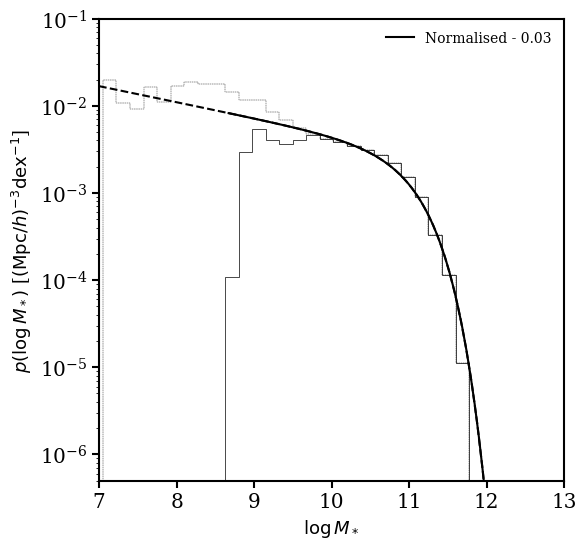

In [26]:
# x_lin = np.linspace(7, 16, 100)
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))

z0 = 0.03
n, I = normalisation(bgs, f_area, z0, mcmc[:,1])

plt.figure(figsize=(6,6))


# plt.plot(x_lin, smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), label='not Normalised')

plt.plot(x_lin_ext, n * smf_single_schechter_sty_z0(x_lin_ext, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc),
        linestyle='--', c='k')
plt.plot(x_lin, n * smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), label=f'Normalised - {z0}', c='k')
_h, _be, _ = norm_hist(bgs, zmin, zmax)
norm_hist_all(bgs, zmin, zmax)

plt.yscale('log')
plt.xlabel(r'$\log M_*$', fontsize=13)
plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=13)
plt.legend(loc='best')
plt.ylim(5e-7, 1e-1)
plt.xlim(7,13)

In [27]:
np.median([0.01,0.05])

0.030000000000000002

## Emcee - GMM comparison

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_4840/263931258.py:28: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


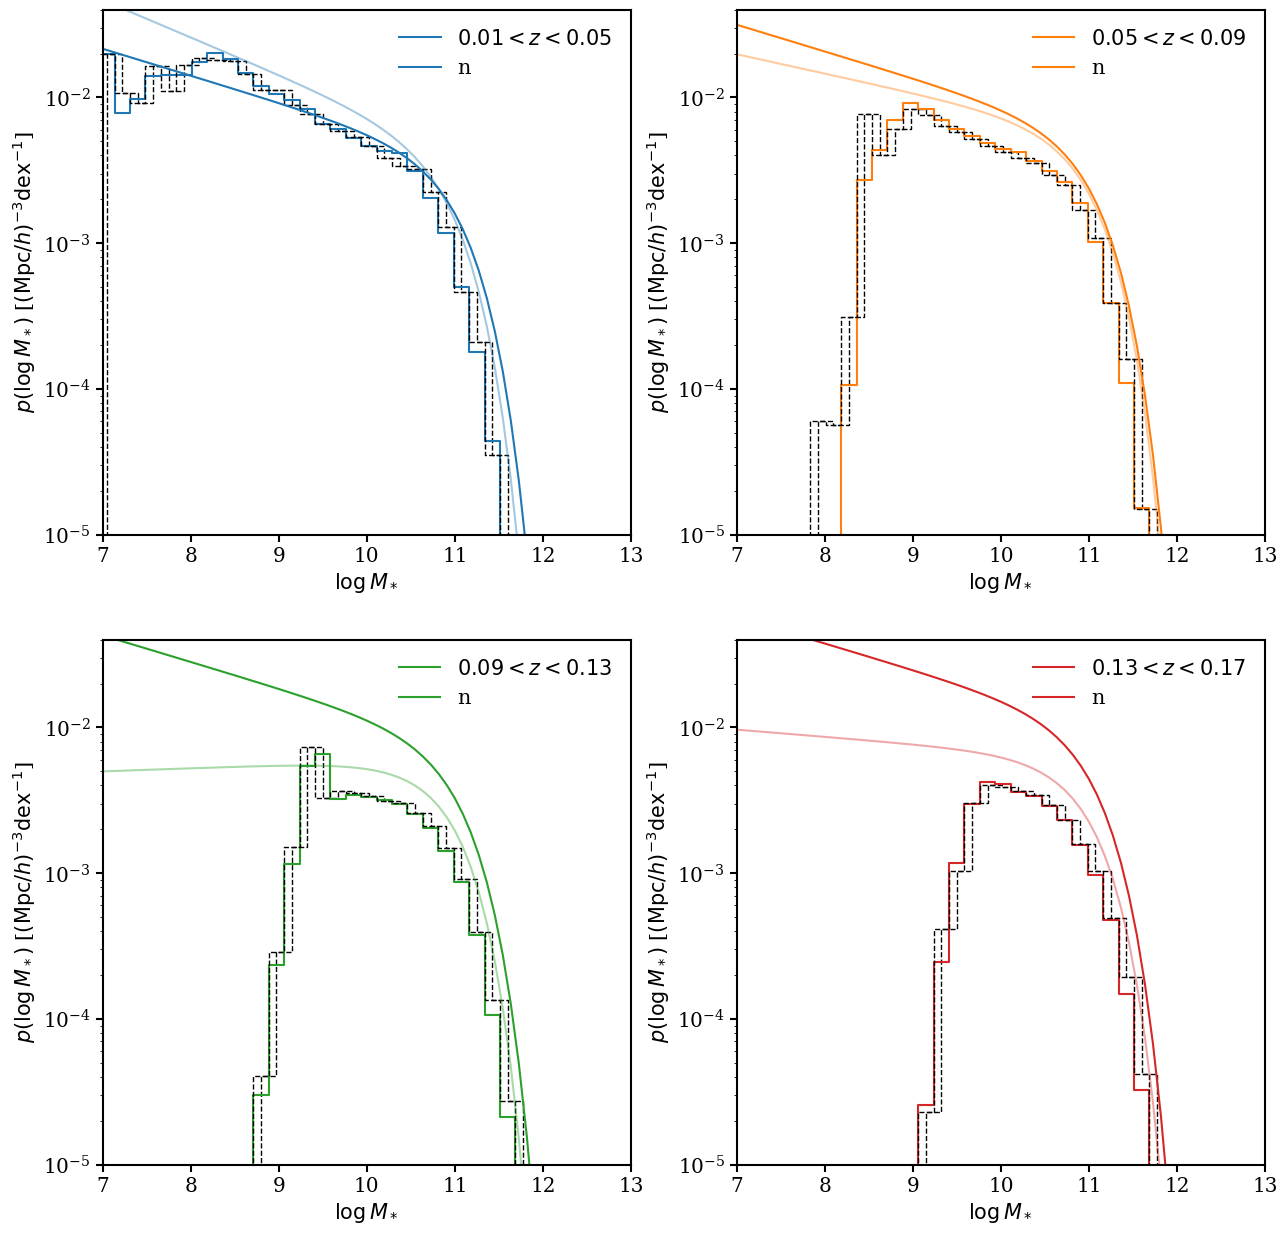

In [28]:
_zmin, _zmax, mlim = np.loadtxt(os.path.join(data_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])

zmins = np.array([0.01 + 0.04 * i for i in range(4)])
zmaxs = np.array([0.05 + 0.04 * i for i in range(4)])

if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = 'cpu'


x_lin = np.linspace(7, 16, 100)

fig = plt.figure(figsize=(15,15))

logM_emcee = []
alpha1_emcee = []

for i, zmin, zmax, z0 in zip(range(4), zmins, zmaxs, (zmins + (zmaxs-zmins))/2 + 0.01):
    plt.subplot(2,2,i+1)
    
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(gmm_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization
    _h, _be, _ = plt.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]/np.sum(w_import[zlim]) * norm, 
             range=(6., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=1) 
    
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)

    # Plotting GMM
    plt.step(be[:-1], h, where='mid', color='C%i' % i, linestyle='-')
    plt.step(_be[:-1], _h, where='mid', color='k', linestyle='--', linewidth=1)
    plt.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

    # Plotting Emcee - z-dependent Schechter
    emcee_run = os.path.join(emcee_runs_dir, filename)
    reader = emcee.backends.HDFBackend(emcee_run)
    flat_samples = reader.get_chain(discard=80, thin=15, flat=True)
    mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(flat_samples.shape[1])])
    best_params = mcmc[:,1]
    a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc = best_params

    z, x, x_median, w_spec, v_max = gathering_data(bgs, zmin, zmax)

    
    n, I = normalisation(bgs, f_area, z0, best_params)
    # n2 = normalisation2(f_area, zmin, zmax, w_spec)
    plt.plot(x_lin, n * smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), c='C%i' % i, label="n")
    # plt.plot(x_lin, 0.0061350113914539805 * smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), c='C%i' % i)
    # plt.plot(x_lin, n2 * smf_single_schechter_sty_z0(x_lin, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), c='C%i' % i, alpha=0.4)


    # Plot the No z-dependence Schechter
    noz_emcee_run = os.path.join(emcee_runs_dir,'NozSchechter_20w_300step_%.2f_%.2f.h5' % (zmin, zmax))
    noz_reader = emcee.backends.HDFBackend(noz_emcee_run)
    noz_flat_samples = noz_reader.get_chain(discard=80, thin=15, flat=True)
    noz_mcmc = np.array([np.percentile(noz_flat_samples[:, i], [16, 50, 84]) for i in range(noz_flat_samples.shape[1])])
    noz_best_params = noz_mcmc[:,1]
    logM_mcmc, alpha1_mcmc = noz_best_params

    noz_z, noz_x, noz_x_median, noz_w_spec, noz_v_max, noz_v_zmax, noz_v_zmin = noz_gathering_data(bgs, zmin, zmax)
    
    noz_n, noz_I = noz_normalisation(f_area, noz_w_spec, noz_v_max, noz_v_zmin, noz_z, noz_best_params)
    # n2 = normalisation2(f_area, zmin, zmax, w_spec)
    plt.plot(x_lin, noz_n * noz_smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), c='C%i' % i, alpha=0.4)
    # plt.plot(x_lin, n2 * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), c='C%i' % i, alpha=0.4)

    logM_emcee.append(logM_mcmc)
    alpha1_emcee.append(alpha1_mcmc)

    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.xlim(7., 13.)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)

In [29]:
n

0.010601987006352535

## $\log M_{*}(z)$ & $\alpha1(z)$ comparison

In [30]:
def logM_z(z, a0, a1):
    return a0 + a1 * z

def alpha1_z(z, a2, a3):
    return a2 + a3 * z

In [31]:
popt_logM, _ = curve_fit(logM_z, zmins + (zmaxs - zmins)/2., logM_emcee)
popt_alpha1, _ = curve_fit(alpha1_z, zmins + (zmaxs - zmins)/2., alpha1_emcee)

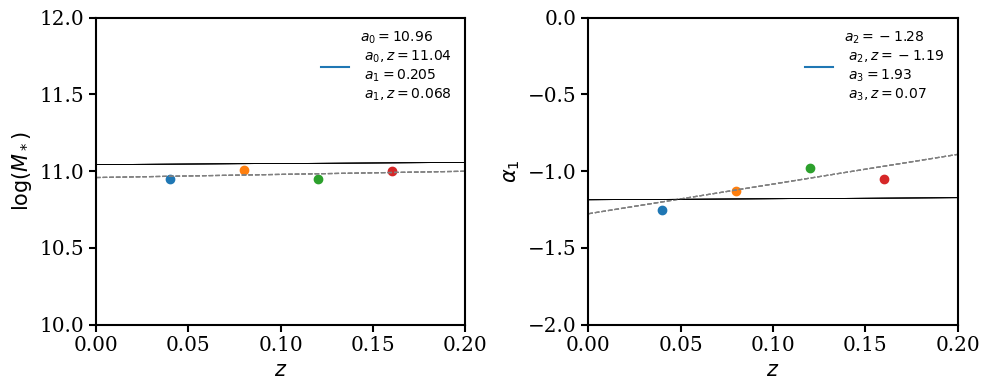

In [32]:
fig = plt.figure(figsize=(10,4))

z_lin = np.linspace(0, 0.2, 200)

for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    plt.subplot(1,2,1)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, logM_emcee[i], c='C%i' % i)
    plt.plot(z_lin, logM_z(z_lin, popt_logM[0], popt_logM[1]), c='grey', alpha=0.8, linewidth=0.9, linestyle='--')
    plt.plot(z_lin, logM_z(z_lin, a0_mcmc, a1_mcmc), c='black', linewidth=0.5)
    if i == 0:
        plt.plot([], [], label= f"$a_0 = {round(popt_logM[0],2)}$ \n $a_0,z  = {round(a0_mcmc,2)}$ \n $a_1 = {round(popt_logM[1],3)}$ \n $a_1,z = {round(a1_mcmc,3)}$")
    
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\log (M_*)$', fontsize=15)
    plt.ylim(10., 12.)
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.scatter(zmin + (zmax-zmin)/2. + 0.01, alpha1_emcee[i], c='C%i' % i)
    plt.plot(z_lin, alpha1_z(z_lin, popt_alpha1[0], popt_alpha1[1]), c='grey', alpha=0.8, linewidth=0.9, linestyle='--')
    plt.plot(z_lin, alpha1_z(z_lin, a2_mcmc, a3_mcmc), c='black', linewidth=0.5)
    if i == 0:
        plt.plot([], [], label= f"$a_2 = {round(popt_alpha1[0],2)}$ \n $a_2,z = {round(a2_mcmc,2)}$ \n $a_3 = {round(popt_alpha1[1],2)}$ \n $a_3,z = {round(a3_mcmc,2)}$")
    
    plt.xlabel(r'$z$', fontsize=15)
    plt.xlim(0., 0.2)
    plt.ylabel(r'$\alpha_1$', fontsize=15)
    plt.ylim(-2., 0.)
    plt.legend(loc='best')

fig.tight_layout()
plt.show()

In [33]:
noz_n, n

(0.0061350113914539805, 0.010601987006352535)

In [34]:
logM_z(z0, a0_mcmc, a1_mcmc), alpha1_z(z0, a2_mcmc, a3_mcmc)

(11.048916288381253, -1.1806233292963577)